### Installations

In [ ]:
!pip install torch
!pip install sb3-contrib
!pip install stable_baselines
!pip install gym[box2d]==0.21.0
!pip install tqdm
# h5py.h5.H5PYConfig' has no attribute '__reduce_cython__'
# https://github.com/h5py/h5py/issues/1477#issuecomment-767677551

### Imports

In [ ]:
import torch as th
import tensorflow as tf
import gym
import os

models_dir = "models/TRPO"
logdir = "logs"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(logdir):
    os.makedirs(logdir)

from sb3_contrib import TRPO
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

print("Gym version: ",gym.__version__)
print("torch version: ",th.__version__)
print("tensorflow version: ",tf.__version__)
if(th.cuda.is_available()): 
    device = torch.device('cuda:0') 
    th.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

### Test The Gym Environment

In [ ]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()
print("sample action: ", env.action_space.sample())
print("Obsevation space action: ", env.observation_space.shape)
print("sample observation: ", env.observation_space.sample())

### Train And Save the Agent

In [69]:
num_features = 32
num_layers = 2
episodes = 100
# Custom actor (pi) and value function (vf) networks
# Custom MLP policy of three layers of size 128 each
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[num_features]*num_layers, vf=[num_features]*num_layers)]) 

env = gym.make('LunarLanderContinuous-v2')
model = TRPO('MlpPolicy', env, policy_kwargs=policy_kwargs, gamma=0.99, target_kl=0.01, batch_size=64, learning_rate=0.0001, tensorboard_log=logdir)


model_name = "trpo_{}Feature_{}Layer_{}Episo_{}BatchS_{}γ_{}LearnR_{}TargetKL".format(num_features,num_layers,
                                                                             episodes,model.batch_size,model.gamma,
                                                                             model.learning_rate,model.target_kl)
# reward_per_episode = []
for episode in trange(episodes):
    model = model.learn(total_timesteps=1000, reset_num_timesteps=False, log_interval=100, tb_log_name="TRPO_128F_3L")
    #save model every total_timesteps steps
    # model.save(f"{models_dir}/{TIMPSTEPS * episode}")
    model.save(f"{models_dir}/{model_name}")
    state = env.reset()
    # total_reward, total_step = 0, 0
    # while True:
    #     action, _state = model.predict(state)
    #     next_state, reward, done, _ = env.step(action)
    #     state = next_state
    #     total_reward += reward
    #     total_step += 1
    #     if done:
    #         env.reset()
    #         reward_per_episode.append(total_reward)
    #         break

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:42<00:00,  4.02s/it]


### Test The Trained Model

In [ ]:
#Delete the model just trainned if u want to load another model in saved files
del model

In [ ]:

model = TRPO.load(f"{models_dir}/{model_name}")

reward_per_episode = []
steps_per_episode = []
for episode in trange(100):
    total_reward, total_step = 0, 0
    while True:
        action, _state = model.predict(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        total_step += 1
        if done:
            env.reset()
            reward_per_episode.append(total_reward)
            steps_per_episode.append(total_step)
            break

 34%|███████████████████████████▌                                                     | 34/100 [00:59<01:52,  1.71s/it]

### Results

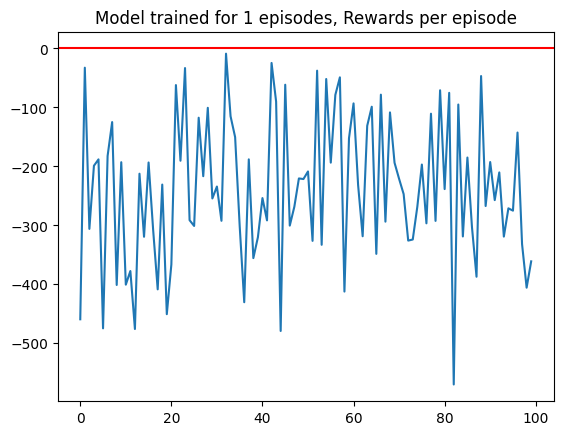

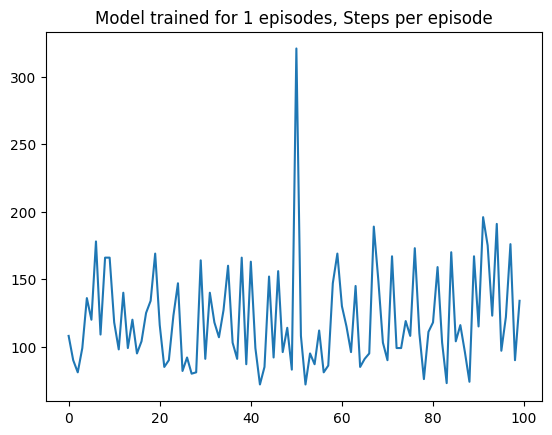

In [63]:
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.plot(reward_per_episode)
plt.title("Model trained for {} episodes, Rewards per episode".format(episodes))
plt.show()

plt.plot(steps_per_episode)
plt.title("Model trained for {} episodes, Steps per episode".format(episodes))
plt.show()